In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}


In [0]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def getdataloader_sizes(batchsize): 
  dataset_directory = 'drive/My Drive/dataset'
  image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_directory, x),data_transforms[x])for x in ['train', 'validation', 'test']}
  #Batch size is set as 64 
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize,
                                               shuffle=True, num_workers=8)
                for x in ['train', 'validation' ,'test']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','test']}

  print({x: len(image_datasets[x]) for x in ['train', 'validation','test']})
  class_names = image_datasets['train'].classes
  return dataloaders,dataset_sizes,class_names

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [8]:

model= models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:18<00:00, 29.6MB/s]


In [0]:
def plot_graph(plotlist1,plotlist2,ylabel):
   #Plot accuracy graph 
    plt.xlabel("Training Epochs")
    plt.ylabel(ylabel)
    plt.plot(plotlist1, color="green")
    plt.plot(plotlist2, color="yellow")
    
    plt.gca().legend(('Train', 'Validation'))
    plt.show()

In [0]:
def train_model(model, criterion, optimizer, epoch_number,device,earlystopping):
   
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_val_acc = 0.0
    best_test_acc = 0.0
    train_acc_history = list()
    train_loss_history =list()
    val_acc_history = list()
    val_loss_history =list()
    
    counter = 0
    stop =False
    best_loss = None
    
    #early stopping
    n_epochs_stop = 1
    min_val_loss = np.Inf
    epochs_no_improve = 0
    
    for epoch in range(epoch_number):
        if stop:
          break
        print('Epoch {}/{}'.format(epoch, epoch_number - 1))
        
        # Each epoch has a training and validation phase
        for part in ['train', 'validation']:
            if part == 'train':
                
                model.train()  
            else:
                model.eval()  

            current_loss = 0.0
            current_phase_correct_outputnumber = 0
            # For each phase in datasets are iterated
            for inputs, labels in dataloaders[part]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(part == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Backpropagate and opitimize Training part
                    if part == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                current_loss += loss.item() * inputs.size(0)
                current_phase_correct_outputnumber += torch.sum(preds == labels.data)

            current_loss = current_loss / dataset_sizes[part]
            epoch_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes[part]

            if part == 'validation':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(current_loss)
                if earlystopping:
                  # If the validation loss is at a minimum
                  if current_loss < min_val_loss:
                    # Save the model
                    epochs_no_improve = 0
                    min_val_loss = current_loss

                  else:
                    epochs_no_improve += 1
                    # Check early stopping condition
                    if epochs_no_improve == n_epochs_stop:
                      print('Early stopping!')
                      
                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      print()

                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      # load best model weights
                      model.load_state_dict(best_model_wts)
                      #Plot accuracy graph 
                      plot_graph(train_acc_history,val_acc_history,"Accuracy")
                      plot_graph(train_loss_history,val_loss_history,"Loss")
                      
                      return model                  
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(current_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                part, current_loss, epoch_acc))

            # deep copy the model
            if part == 'train' and epoch_acc > best_train_acc:
                  best_train_acc = epoch_acc
                
            if part == 'validation' and epoch_acc > best_val_acc:             
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              
        print() 
    
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best validation Acc: {:4f}'.format(best_val_acc))
              
    print()
    #Printed best accuracies
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best validation Acc: {:4f}'.format(best_val_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    #Plot accuracy graph 
    plot_graph(train_acc_history,val_acc_history,"Accuracy")
    plot_graph(train_loss_history,val_loss_history,"Loss")
  
    return model


{'train': 998, 'validation': 228, 'test': 308}
Epoch 0/15
train Loss: 2.2321 Acc: 15.9319
validation Loss: 2.1881 Acc: 14.4737

Epoch 1/15
train Loss: 2.2020 Acc: 17.2345
validation Loss: 2.1575 Acc: 18.4211

Epoch 2/15
train Loss: 2.1752 Acc: 17.4349
validation Loss: 2.1292 Acc: 21.0526

Epoch 3/15
train Loss: 2.1587 Acc: 19.0381
validation Loss: 2.1025 Acc: 22.8070

Epoch 4/15
train Loss: 2.1452 Acc: 19.9399
validation Loss: 2.0775 Acc: 25.0000

Epoch 5/15
train Loss: 2.1153 Acc: 21.8437
validation Loss: 2.0533 Acc: 26.7544

Epoch 6/15
train Loss: 2.0632 Acc: 25.1503
validation Loss: 2.0308 Acc: 27.6316

Epoch 7/15
train Loss: 2.0697 Acc: 23.1463
validation Loss: 2.0085 Acc: 30.7018

Epoch 8/15
train Loss: 2.0273 Acc: 27.8557
validation Loss: 1.9869 Acc: 34.6491

Epoch 9/15
train Loss: 2.0031 Acc: 28.3567
validation Loss: 1.9665 Acc: 36.8421

Epoch 10/15
train Loss: 2.0045 Acc: 26.5531
validation Loss: 1.9463 Acc: 37.7193

Epoch 11/15
train Loss: 1.9752 Acc: 29.2585
validation Loss: 

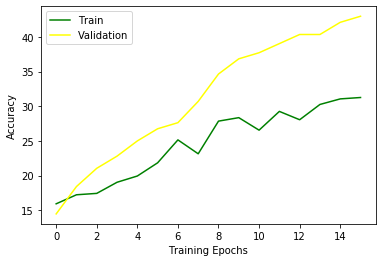

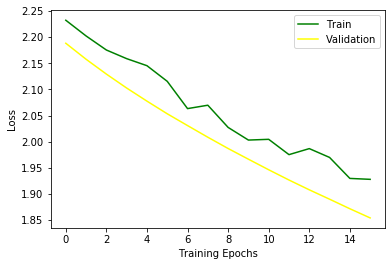

In [12]:
trainingmodel= models.vgg16(pretrained=True)
for param in trainingmodel.features.parameters():
    param.requires_grad = False
    
learning_rate = 0.001
epoch = 32
batchsize = 32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trainingmodel.parameters(), lr=learning_rate)
earlystoping = False

num_ftrs = trainingmodel.classifier[6].in_features

#Last layer is removed and modified with a linear layer
trainingmodel.classifier[6] = nn.Linear(num_ftrs,9)

dataloaders,dataset_sizes,class_names = getdataloader_sizes(batchsize)


trained_model = train_model(trainingmodel, criterion, optimizer,epoch,device,earlystoping)



In [0]:
def calculateTestAcc(trained_model,dataloaders,dataset_sizes):
  confusion_matrixx = torch.zeros(9, 9)
  np.set_printoptions(precision=2)
  current_phase_correct_outputnumber = 0

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        current_phase_correct_outputnumber += torch.sum(preds == classes.data)
        
      
        
       
          
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrixx[t.long(), p.long()] += 1
    #### Top 1 score
    test_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes['test']
    #### top5 score
  
    
    #Top 1 and Top 5 accuracies printed
    print('Test Acc: {:4f}'.format(test_acc))

  #Plot size is set
  plt.figure(figsize = (10,10))
  plot_confusion_matrix(confusion_matrixx,classes=class_names)
  plt.show()

Test Acc: 37.987013


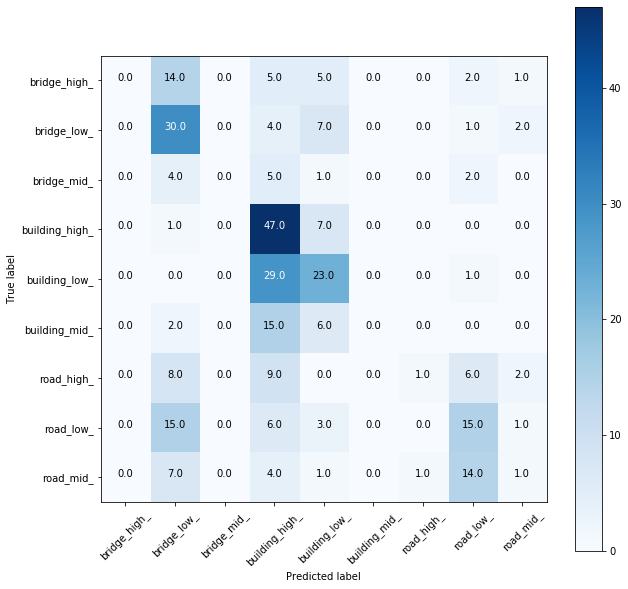

In [15]:

calculateTestAcc(trained_model,dataloaders,dataset_sizes)